In [1]:
from a72_utilities import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 200
from scipy.ndimage import binary_dilation, binary_erosion

This workbook is for looking at the average spectra for the five different phases we've identified for each element

In [2]:
xas_data, old_masks, xas_energies = load_registered_xas()
aligned_masks = load_phase_masks()

In [3]:
print(aligned_masks.keys())

dict_keys(['Al phase', 'Islands', 'Ti-rich', 'L21', 'FCC'])


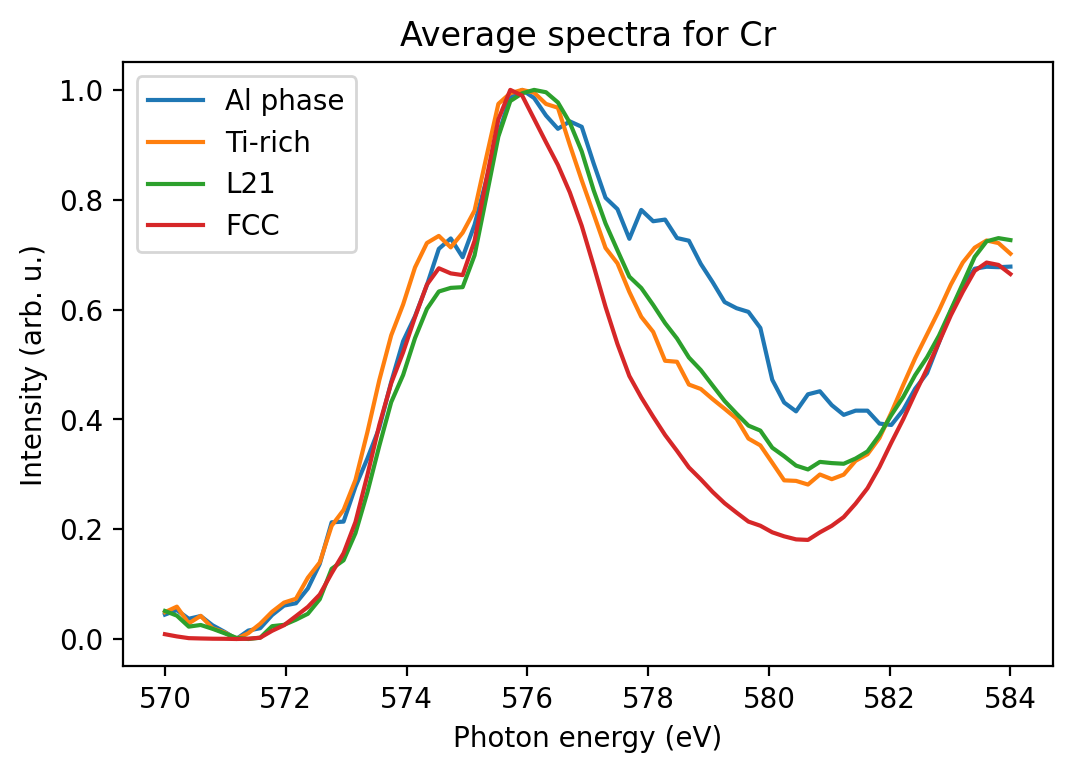

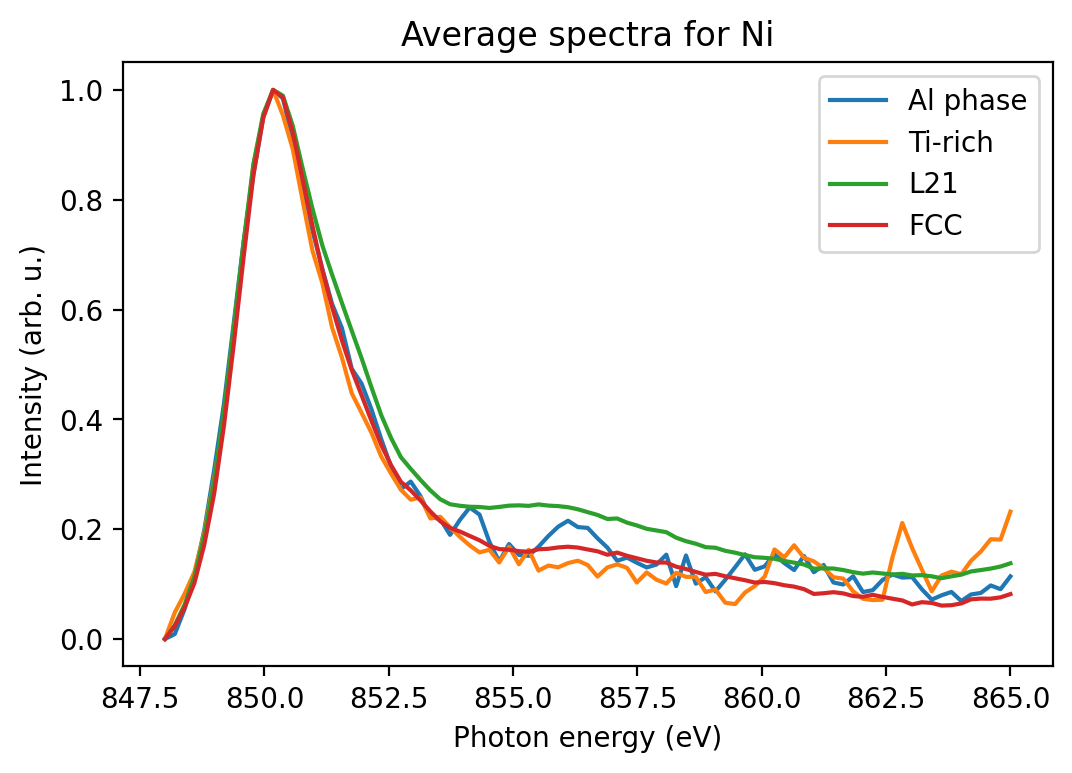

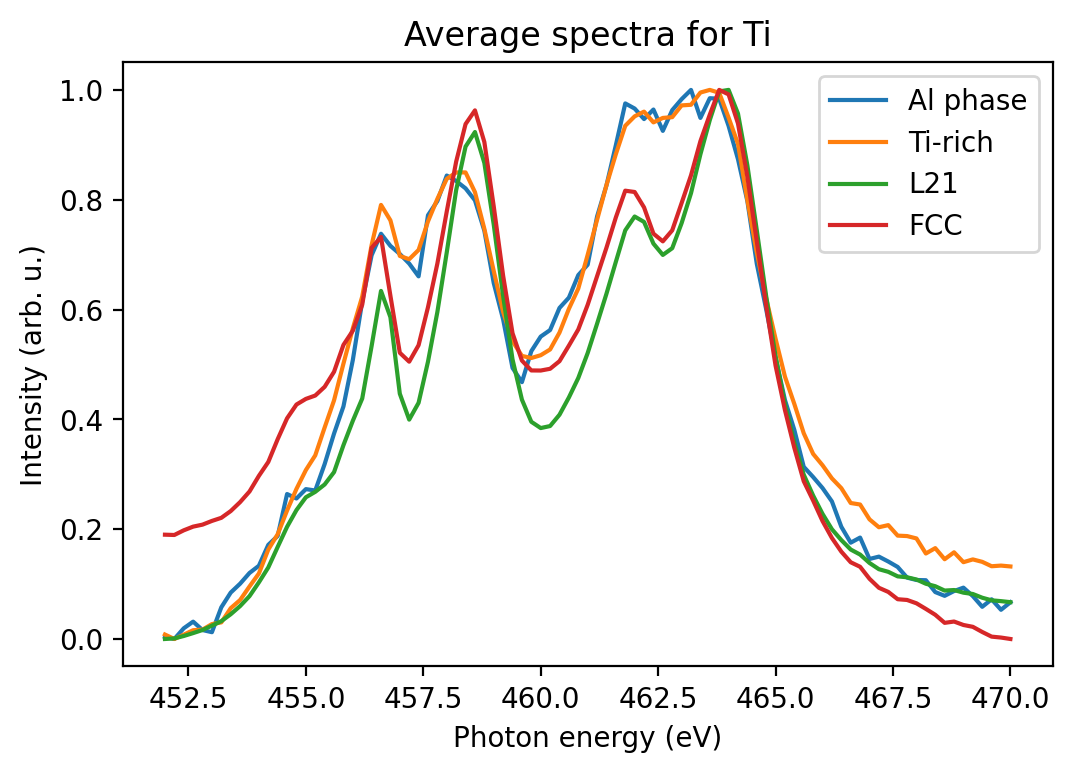

KeyboardInterrupt: 

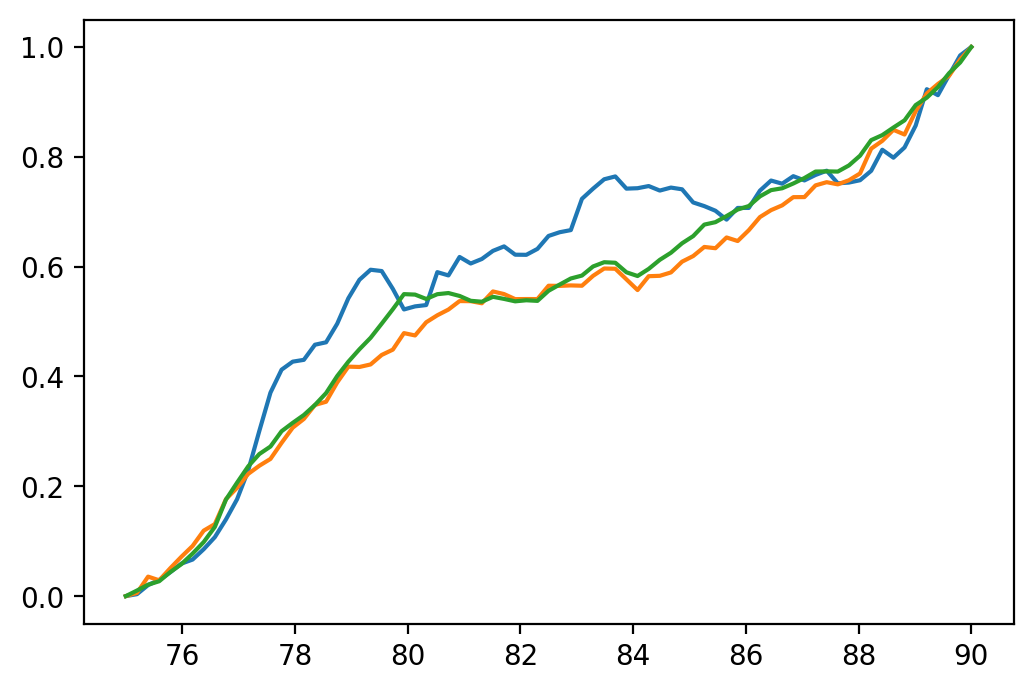

In [10]:
#plot average spectra of the matrix and l12 phases for all of the elements

average_spectra = pd.DataFrame(index=range(200))
concentrations = pd.DataFrame()
concentrations['Phase'] = aligned_masks.keys()
phaselist = []
for i, (element, xas) in enumerate(xas_data.items()):
    phase_concentrations = []
    for j, (phase,mask) in enumerate(aligned_masks.items()):
        if phase == 'Islands':
            continue

        #Get the average spectra for each phase by masking the XAS data
        phaselist.append(phase)
        segmented = mask_subtract_arr(trim_edges(xas,border=30), mask)
        segmented = segmented.astype(float)
        segmented[segmented == 0.] = np.nan
        phase_concentrations.append((np.nanmean(segmented)))

        #store the average spectra in a dataframe
        average_spectra['energy_'+element+"_"+phase] = pd.Series((xas_energies[element]))
        average_spectra['intensity_'+element+"_"+phase] = pd.Series(normalize_array(np.nanmean(segmented,axis=(1,2))))


        #plt.plot(xas_energies[element],0.1*j+normalize_array(np.nanmean(segmented,axis=(1,2))))
        plt.plot(xas_energies[element],normalize_array(np.nanmean(segmented,axis=(1,2))))
    concentrations[element] = pd.Series(phase_concentrations)

    
    plt.xlabel("Photon energy (eV)")
    plt.legend(phaselist)
    plt.ylabel("Intensity (arb. u.)")
    plt.title("Average spectra for "+ element)
    plt.show()

"""Copy the average spectra to the clipboard for figure 5 in the paper"""
average_spectra.to_clipboard()
concentrations.head()

In [5]:
"""Find the average intensity for each element in the FCC matrix phase"""
element_averages_fcc = {}
for i, (element, xas) in enumerate(xas_data.items()):
    segmented = mask_subtract_arr(trim_edges(xas,border=30),aligned_masks['FCC'],return_nan=True)
    element_averages_fcc[element] = np.nanmean(segmented)


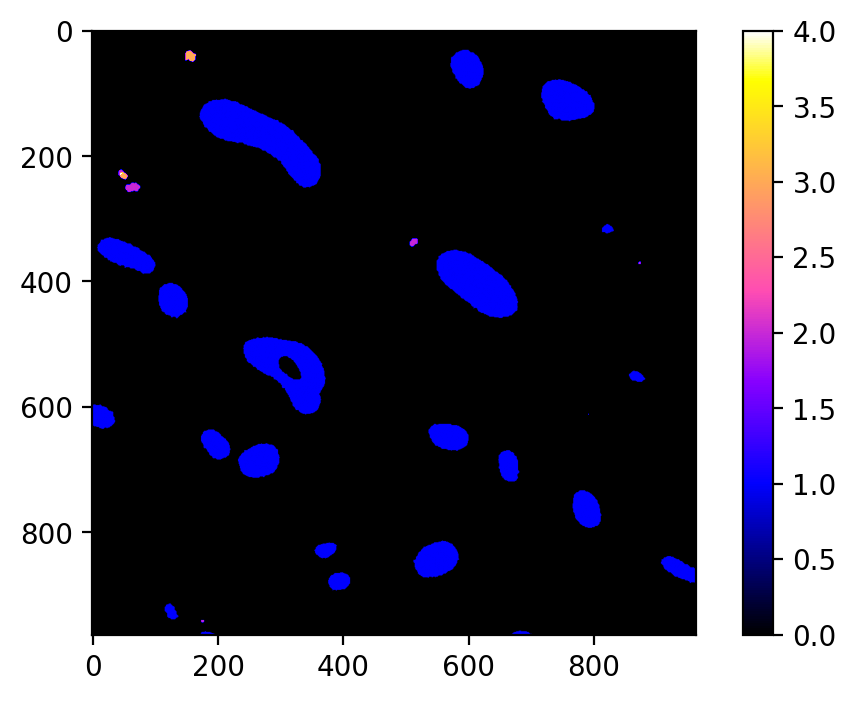

In [9]:


plt.imshow(normalize_array(aligned_masks['L21'])+normalize_array(aligned_masks['Ti-rich'])*2+normalize_array(aligned_masks['Al phase'])*3,cmap = 'gnuplot2',vmin=0,vmax=4)
plt.colorbar()

Code developed to get radial slicees across the phase boundary so that we can visualize how sharp the interface is

In [7]:
def get_radial_slices(mask, nsteps = 5):
    """Get the radial slices by eroding and dilating the mask n times.  Erosion is saved with a negative integer key, and dilation is saved witha  positive integer key.  
    
    Args:
        mask (ndarray): The mask to be processed
        nsteps (int): The number of steps for dilation and erosion
    Returns:
        borders (dict): a dictionary of the radial slices for each step of erosion and dilation, with the key being the integer step number. 
        
    """

    border_stack = np.zeros(mask.shape)
    borders = {}

    for i in range(1,1+nsteps):
        erosion = binary_erosion(mask,iterations=i).astype(int)
        if i ==1:
            erosion = normalize_array(mask).astype(int)-erosion
        if i > 1:
            erosion = binary_erosion(mask,iterations=i-1).astype(int)-erosion
        borders[str(-i)] = erosion
        border_stack += erosion*-i

    for i in range(1,1+nsteps):
        dilation = binary_dilation(mask,iterations=i).astype(int)
        if i ==1:
            dilation = dilation-normalize_array(mask).astype(int)
        if i > 1:
            dilation = dilation-binary_dilation(mask,iterations=i-1).astype(int)
        borders[str(i)] = dilation
        border_stack += dilation*i

    plt.imshow(border_stack,cmap='bwr')
    plt.colorbar()
    plt.show()

    return borders

def get_concentrations(border_dict, xas_data_df):

    """Get the average concentration of each element in the radial slices of the mask.  The average is taken over the entire slice, and the result is stored in a dataframe.
    
    Args:
        border_dict (dict): A dictionary of the radial slices for each step of erosion and dilation, with the key being the integer step number. 
        xas_data_df (DataFrame): A dataframe of the XAS data, with the index being the energy and the columns being the elements.
    
    Returns:
        concentrations (DataFrame): A dataframe of the average concentration of each element in the radial slices of the mask, with the index being the step number and the columns being the elements and the step number saved in a column named 'distance'.
    """

    concentrations = pd.DataFrame()

    for i, (distance,mask) in enumerate(border_dict.items()):
        concentrations.at[i,'distance'] = int(distance)
        for j, (element,data) in enumerate(xas_data_df.items()):
            concentrations.at[i,str(element)] = np.nanmean(mask_subtract_arr(trim_edges(data,border=30), mask,return_nan=True))
    concentrations.sort_values(by="distance",inplace=True)
    return concentrations

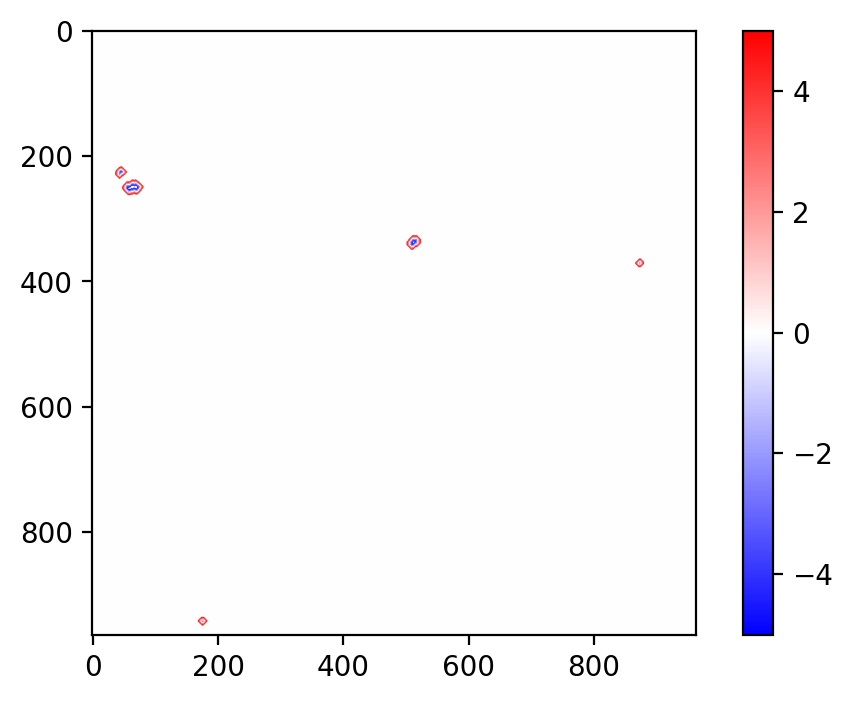

In [11]:
al_borders = get_radial_slices(aligned_masks["Ni depleted"],nsteps=5)
al_concentrations = get_concentrations(al_borders, xas_data)

Text(0, 0.5, 'Normalized intensity (arb. u.)')

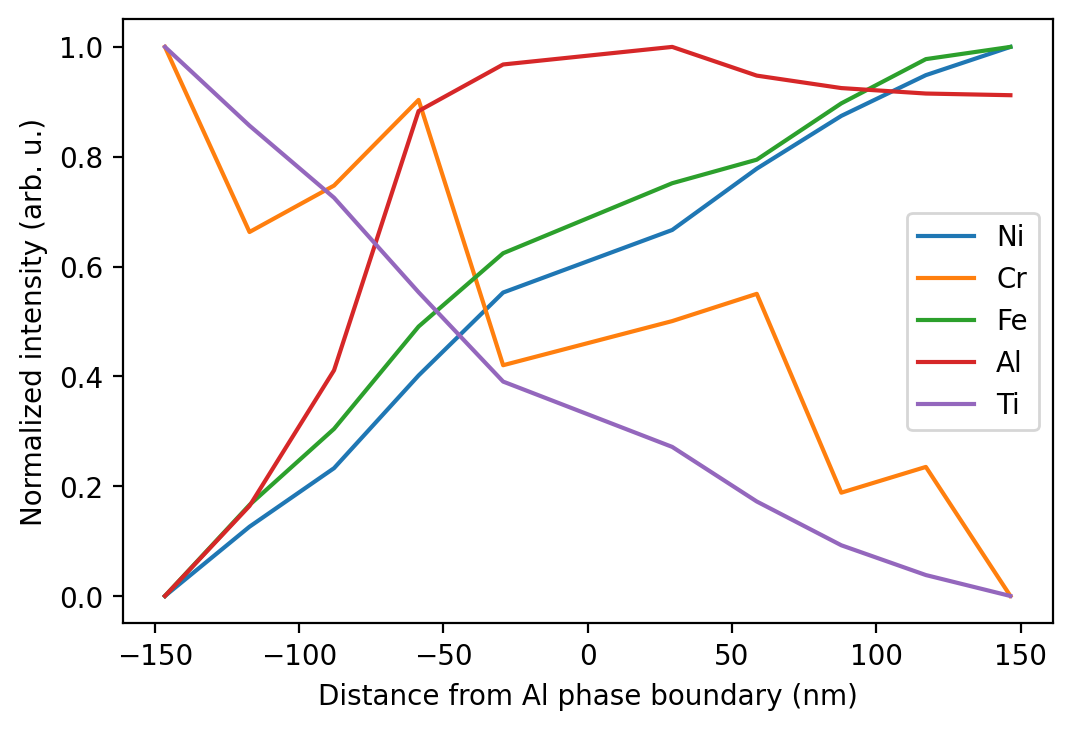

In [12]:
plt.plot(al_concentrations['distance']*29.3,normalize_array(al_concentrations['Ni']))
plt.plot(al_concentrations['distance']*29.3,normalize_array(al_concentrations['Cr']))
plt.plot(al_concentrations['distance']*29.3,normalize_array(al_concentrations['Fe']))
plt.plot(al_concentrations['distance']*29.3,normalize_array(al_concentrations['Al']))
plt.plot(al_concentrations['distance']*29.3,normalize_array(al_concentrations['Ti']))
plt.legend(['Ni','Cr','Fe','Al','Ti'])
plt.xlabel("Distance from Al phase boundary (nm)")
plt.ylabel("Normalized intensity (arb. u.)")

Text(0, 0.5, 'Intensity relative to FCC')

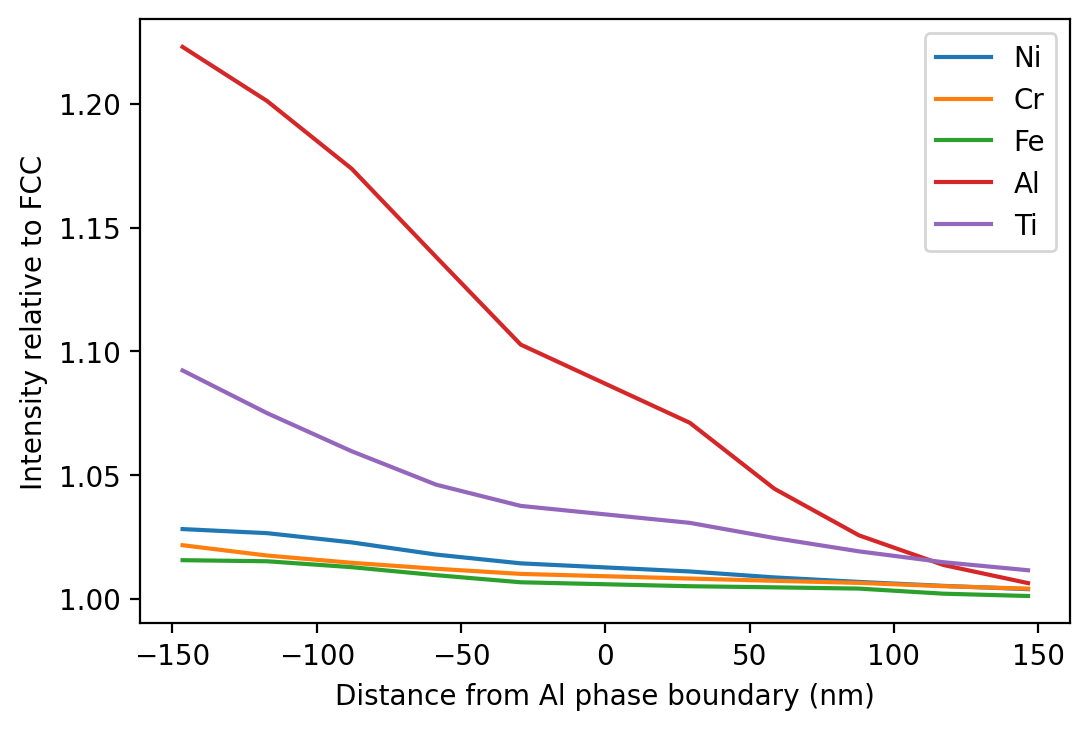

In [10]:
plt.plot(al_concentrations['distance']*29.3,(al_concentrations['Ni'])/element_averages_fcc['Ni'])
plt.plot(al_concentrations['distance']*29.3,(al_concentrations['Cr'])/element_averages_fcc['Cr'])
plt.plot(al_concentrations['distance']*29.3,(al_concentrations['Fe'])/element_averages_fcc['Fe'])
plt.plot(al_concentrations['distance']*29.3,(al_concentrations['Al'])/element_averages_fcc['Al'])
plt.plot(al_concentrations['distance']*29.3,(al_concentrations['Ti'])/element_averages_fcc['Ti'])
plt.legend(['Ni','Cr','Fe','Al','Ti'])
plt.xlabel("Distance from Al phase boundary (nm)")
plt.ylabel("Intensity relative to FCC")